In [1]:
import pandas as pd
import geopandas as gpd

from IPython.display import HTML, display

import matplotlib.pyplot as plt

# Daycare injury analysis

This code analyzes daycares with verified-injury data exported from data warehouse.

The `dat_injure` dataframe has a row for every injury detail and related violation for every operation. Because of this, the code frequently groups by `operation_id` before counting daycares.

In [2]:
dat_injure = pd.read_csv(
    '../csv/daycare-injuries.csv'
).assign(
    related_violation = lambda x: x.related_violation.replace(
            '1f', 'Facility/Equipment'
        ).replace(
            '2r', 'Failure To Report Incident'
        ).replace(
            '3s', 'Staffing'
        ).replace(
            '4s', 'Supervision'
        ).replace(
            '5t', 'Training'
        ),
    injury_detail = lambda x: x.injury_detail.replace(
            '2a', 'Accidental'
        ).replace(
            '3i', 'Intentional'
        ).replace(
            '4m', 'Medical care'
        ).replace(
            '5h', 'Hospital visit'
        ).replace(
            '6m', 'Minor'
        ).replace(
            '7s', 'Serious'
        ).replace(
            '8u', 'Unknown injury'
        ).replace(
            '9i', 'Injury by other child'
        )
).query(
    'activity_date >= "2016-02-01"'
)

In [3]:
# Load data for all daycares in DFPS purview as of Feb. 1

operations = pd.read_csv(
    '../csv/dfps-2018-02-01/operations.csv'
).drop('Unnamed: 0', axis=1)

### Injury detail breakdowns

In [4]:
HTML(
    '<p><strong>{:,}</strong> inspections with an injury</p>'.format(
        len(dat_injure.activity_id.unique())
    )
)

In [5]:
HTML(
    '<p><strong>{:,}</strong> inspections with an injury not reported to parents or licensing</p>'.format(
        len(
            dat_injure.query(
                'related_violation == "Failure To Report Incident"'
            ).activity_id.unique()
        )
    )
)

In [6]:
HTML(
    '<p><strong>{:,}</strong> inspections with an injury that required medical care</p>'.format(
        len(
            dat_injure.query(
                'injury_detail == "Medical care"'
            ).activity_id.unique()
        )
    )
)

In [7]:
HTML(
    '<p><strong>{:,}</strong> inspections with an injury and failure to supervise properly</p>'.format(
        len(
            dat_injure.query(
                'related_violation == "Supervision"'
            ).activity_id.unique()
        )
    )
)

In [8]:
HTML(
    '<p><strong>{:,}</strong> inspections with an injury intentionally caused by daycare caregivers</p>'.format(
        len(
            dat_injure.query(
                'injury_detail == "Intentional"'
            ).activity_id.unique()
        )
    )
)

In [9]:
display(
    dat_injure.groupby([
        'operation_id', 'operation_type'
    ]).size().index.get_level_values(1).value_counts(
    ).apply(pd.Series).apply(
        lambda x: ['{:,}'.format(a) for a in x]
    ).rename(
        columns = {0: ''}
    )
)

display(
    dat_injure.groupby([
        'operation_id', 'operation_type'
    ]).size().index.get_level_values(1).value_counts(
        normalize=True
    ).apply(pd.Series).apply(
        lambda x: ['{:.1%}'.format(a) for a in x]
    ).rename(
        columns = {0: ''}
    )
)

HTML('<p>⬆️ Operations with injuries</p>')

,
Licensed Center,786
Registered Child-Care Home,13
Licensed Child-Care Home,8


,
Licensed Center,97.4%
Registered Child-Care Home,1.6%
Licensed Child-Care Home,1.0%


In [10]:
display(
    operations.query(
        'OPERATION_TYPE != "Child Placing Agency" & OPERATION_TYPE != "General Residential Operation"'
    ).OPERATION_TYPE.value_counts(
        normalize=True
    ).apply(pd.Series).apply(
        lambda x: ['{:.2%}'.format(a) for a in x]
    ).rename(
        columns = {0: ''}
    )
)

HTML('<p>⬆️ All operations, excluding Child Placing Agencies '
      'and General Residential Operations</p>'
     )

,
Licensed Center,63.57%
Registered Child-Care Home,25.20%
Licensed Child-Care Home,11.23%


### Geography (county)

In [11]:
dat_counties = gpd.read_file(
    '/www/home/projects/2018-03-census/web/notebooks/download/tl_2017_us_county'
).query('STATEFP == "48"')

In [12]:
dat_county_pop = pd.read_csv(
    'http://demographics.texas.gov/Resources/TPEPP/Estimates/2016/2016_txpopest_county.csv'
).assign(
    county = lambda x: x.county.str.replace('De Witt', 'DeWitt').str.upper()
).set_index('county')

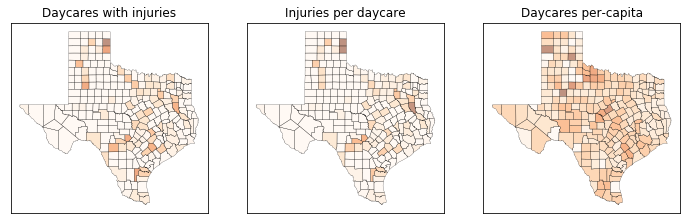

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

dat_counties.assign(
    NAME = lambda x: x.NAME.str.upper()
).set_index('NAME').join(
    dat_injure.groupby([
        'operation_id', 'county'
    ]).size().apply(pd.Series).rename(
        columns = {0: 'county_count'}
    ).reset_index().groupby('county')[
       'county_count'
    ].sum()
).join(dat_county_pop).fillna(0).assign(
    count_per_cap = lambda x: x.county_count / x.july1_2016_pop_est
).plot(
    column='count_per_cap',
    linewidth=0.2,
    cmap='Oranges',
    ax=axes[0]
)
axes[0].set_title('Daycares with injuries')

dat_counties.assign(
    NAME = lambda x: x.NAME.str.upper()
).set_index('NAME').join(
    dat_injure.groupby([
        'operation_id', 'county'
    ]).size().apply(pd.Series).rename(
        columns = {0: 'county_count'}
    ).reset_index().groupby('county')[
       'county_count'
    ].sum()
).join(
    pd.DataFrame(
        operations.query(
            'OPERATION_TYPE != "Child Placing Agency" & OPERATION_TYPE != "General Residential Operation"'
        ).COUNTY.value_counts()
    ).rename(
        columns = {'COUNTY': 'total_daycares'}
    )
).fillna(0).assign(
    injuries_per_daycare = lambda x: (x.county_count / x.total_daycares).replace(1, 0.6)
).plot(
    column='injuries_per_daycare',
    linewidth=0.2,
    cmap='Oranges',
    ax=axes[1]
)

axes[1].set_title('Injuries per daycare')

dat_counties.assign(
    NAME = lambda x: x.NAME.str.upper()
).set_index('NAME').join(
    operations.COUNTY.value_counts().apply(
        pd.Series
    ).rename(
        columns = {0: 'county_count'}
    )
).join(dat_county_pop).fillna(0).assign(
    count_per_cap = lambda x: x.county_count / x.july1_2016_pop_est
).plot(
    column='count_per_cap',
    linewidth=0.2,
    cmap='Oranges',
    ax=axes[2]
)
axes[2].set_title('Daycares per-capita')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

HTML('<p>⬆️ Per-capita daycare counts</p>')

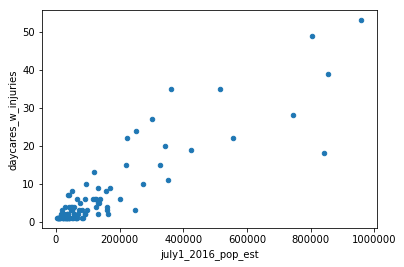

In [14]:
dat_injure.groupby([
        'operation_id', 'county'
    ]).size().apply(pd.Series).rename(
        columns = {0: 'county_count'}
    ).reset_index().groupby('county')[
       'county_count'
    ].sum().apply(pd.Series).rename(
    columns = {0: 'daycares_w_injuries'}
).join(dat_county_pop).fillna(0).assign(
    count_per_cap = lambda x: x.daycares_w_injuries / x.july1_2016_pop_est
).query('july1_2016_pop_est < 1e6').plot(
    kind='scatter',
    x='july1_2016_pop_est',
    y='daycares_w_injuries'
)

plt.show()

### Inspection counts by type

In [15]:
display(
    dat_injure.groupby(
        ['operation_id', 'operation_type']
    )[[
        'total_inspections',
        'total_assessments',
        'total_reports'
    ]].first().groupby('operation_type')[
        'total_inspections',
    ].mean().round()
)

HTML('<p>⬆️ Operations with injuries</p>')

,total_inspections
operation_type,
Licensed Center,11.0
Licensed Child-Care Home,5.0
Registered Child-Care Home,6.0


In [16]:
display(
    operations.query(
        'OPERATION_TYPE != "Child Placing Agency" & OPERATION_TYPE != "General Residential Operation"'
    ).groupby(
        'OPERATION_TYPE'
    )[[
        'TOTAL_INSPECTIONS',
    ]].mean().apply(round)
)

HTML('<p>⬆️ All operations, excluding Child Placing Agencies '
      'and General Residential Operations</p>'
     )

,TOTAL_INSPECTIONS
OPERATION_TYPE,
Licensed Center,6.0
Licensed Child-Care Home,4.0
Registered Child-Care Home,3.0
